In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.geom as afwGeom
import lsst.afw.math as afwMath
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.cameraGeom.utils as cgUtils

In [2]:
afwDisplay.setDefaultBackend("matplotlib")

In [3]:
from lsst.obs.lsst import LsstCamMapper as camMapper
camera = camMapper._makeCamera()

## Routines to read per-amplifier images and convert coordinates to/from CCD pixel coordinates

In [4]:
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms, channelToAmp, getAmpImage

### Put in a raft,detector name by hand

In [5]:
raftName = 'R22'
detectorName = 'S11'
detectorName = "%s_%s" % (raftName, detectorName)

lct = LsstCameraTransforms(camera)

#### Get a DM detector and ask it about itself

In [6]:
det = lct.getDetector(detectorName)
print(det.getName(), det.getType(), det.getPhysicalType(), det.getSerial())

R22_S11 DetectorType.SCIENCE E2V E2V-CCD250-382


#### Convert some CCD coordinates to amp coordinates

Validate this by looking at some images with recognisable pixels

In [7]:
# Choose some pixels to check by eye
cx, cy = 3332, 2500   # C16

#
# Convert from the CCD coordinates to per-amp coordinates
#
channel, ampX, ampY = lct.ccdPixelToAmpPixel(cx, cy, detectorName)

butler = None
if butler is not None:
    #
    # Read the raw amp data, assuming that the butler isn't adding any information
    #
    rawa = getAmpImage(butler, dataId, channel)

    #
    # Display the amp image, showing the selected point
    #
    disp = afwDisplay.Display(4, reopenPlot=True)

    stats = afwMath.makeStatistics(rawa.image, afwMath.MEDIAN | afwMath.STDEVCLIP)
    med = stats.getValue(afwMath.MEDIAN)
    std = stats.getValue(afwMath.STDEVCLIP)
    disp.scale('linear', med - 1*std, med + 2*std)

    disp.mtv(rawa, title=channelToAmp(lct.getDetector(detectorName), channel).getName())
    disp.dot('+', ampX, ampY, ctype=afwDisplay.RED)
    disp.zoom(16, ampX, ampY)

In [8]:
print(channel, ampX, ampY)

10 260 1503


### Plot the whole focal plane

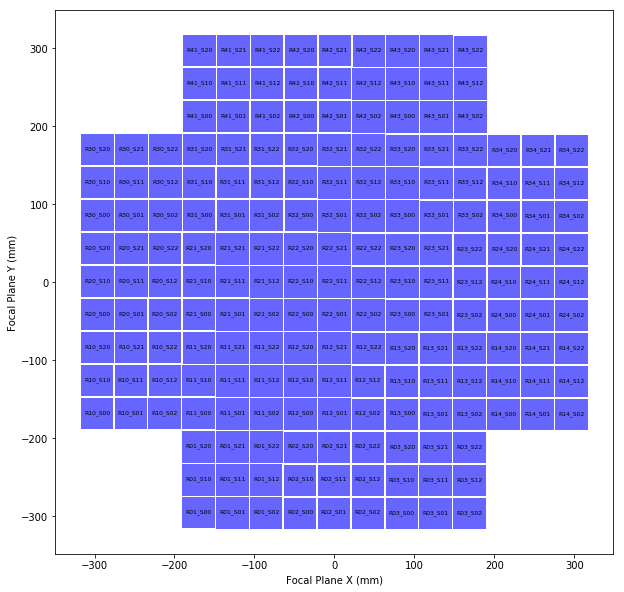

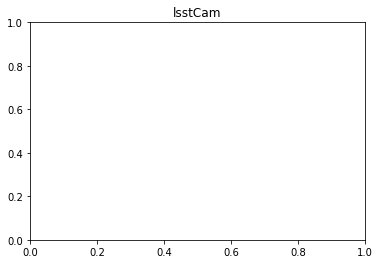

In [9]:
plt.close('all')
cgUtils.plotFocalPlane(camera)
plt.title(camera.getName());

#### Convert a CCD position to focal plane coordinates and plot it

/gpfs/slac/lsst/fs3/g/software/stack/w.2019.37_gcc7/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Call to deprecated function (or staticmethod) Extent2D. (Replaced by lsst.geom.ExtentD (will be removed before the release of v20.0))
  This is separate from the ipykernel package so we can avoid doing imports until


R22_S11 (  -0.500,   -0.500)pix -> ( -20.480,  -20.020)mm
R22_S11 (4095.499, 4003.499)pix -> (  20.480,   20.020)mm


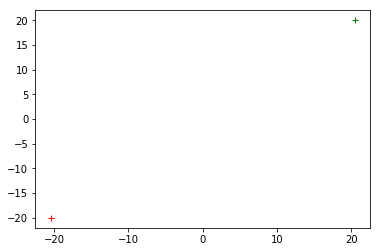

In [10]:

for ccdXY, color in [
    ((-0.5, -0.5), "red"),   # bottom left corner of CCD
    (camera[detectorName].getBBox().getEnd() - afwGeom.ExtentD(0.501, 0.501), "green"),  # top right of CCD
    ]:
    fpXMm, fpYMm = lct.ccdPixelToFocalMm(*ccdXY, detectorName)

    plt.plot(fpXMm, fpYMm, '+', color=color)
    print("%s (%8.3f, %8.3f)pix -> (%8.3f, %8.3f)mm" % (detectorName, ccdXY[0], ccdXY[1], fpXMm, fpYMm))

R22_S11 (   0.000,    0.000)pix -> ( -20.475,  -20.015)mm


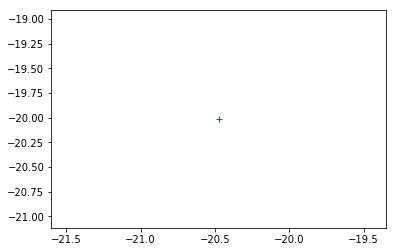

In [11]:
ccdXY = [0.,0.]    
fpXMm, fpYMm = lct.ccdPixelToFocalMm(*ccdXY, detectorName)
plt.plot(fpXMm, fpYMm, '+', color=color)
print("%s (%8.3f, %8.3f)pix -> (%8.3f, %8.3f)mm" % (detectorName, ccdXY[0], ccdXY[1], fpXMm, fpYMm))

In [12]:
camera[detectorName].getBBox().getEnd()

Point2I(4096, 4004)

#### Demonstrate the reverse mapping;  focal plane back to CCD

In [13]:
dname, ccdX, ccdY = lct.focalMmToCcdPixel(fpXMm, fpYMm)
print("(%.3f, %.3f)mm -> %s (%.3f, %.3f)pix" % (fpXMm, fpYMm, dname, ccdX, ccdY))

(-20.475, -20.015)mm -> R22_S11 (0.000, 0.000)pix


In [14]:
dname = 'R22_S11'
cx, cy=0,0
lct.ccdPixelToAmpPixel(cx,cy,dname)
#cx, cy= 1018,0
#lct.ccdPixelToAmpPixel(cx,cy,dname)

(1, 511, 0)

#### And focal plane to amplifier

In [15]:
fpXMm, fpYMm = 2.5, 10
dname, channel, ampX, ampY = lct.focalMmToAmpPixel(fpXMm, fpYMm)
print("(%.3f, %.3f)mm -> %s channel %d (%.3f, %.3f)pix" % (fpXMm, fpYMm, dname, channel, ampX, ampY))

(2.500, 10.000)mm -> R22_S11 channel 12 (250.000, 1001.000)pix


In [16]:
a = 2
b = 0
c = 1
d = 1

x_cam = 127.00*(a - 2) + 42.25*(c - 1)
y_cam = 127.00*(b - 2) + 42.25*(d - 1)
print(x_cam, y_cam)
fpXMm, fpYMm = y_cam, x_cam
dname, channel, ampX, ampY = lct.focalMmToAmpPixel(fpXMm, fpYMm)
print("(%.3f, %.3f)mm -> %s channel %d (%.3f, %.3f)pix" % (fpXMm, fpYMm, dname, channel, ampX, ampY))

0.0 -254.0
(-254.000, 0.000)mm -> R20_S11 channel 5 (498.000, 1940.000)pix


In [ ]:
if butler is not None:
    #
    # Read the raw amp data, assuming that the butler isn't adding any information
    #
    rawa = getAmpImage(butler, dataId, channel)

    #
    # Display the amp image, showing the selected point
    #
    disp = afwDisplay.Display(5, reopenPlot=True)

    disp.scale('asinh', 'zscale', Q=2)

    disp.mtv(rawa, title=channelToAmp(lct.getDetector(detectorName), channel).getName())
    disp.dot('+', ampX, ampY, ctype=afwDisplay.RED)
    disp.zoom(32, ampX, ampY)